# **Train Model Using Pipeline**

## **LOAD DATASET**

In [21]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import joblib
import os
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

In [2]:
ACCURACY_TARGET = float(os.getenv("ML_CLASSIFIER_ACCURACY_TARGET", 0.85))
TFIDF_MAX_FEATURES = int(os.getenv("ML_CLASSIFIER_TFIDF_MAX_FEATURES", 5000))

In [3]:
# ================================
# 1. LOAD DATASET
# ================================
DATA_PATH = "../data/classification_dataset.csv"  

df = pd.read_csv(DATA_PATH)

# Ensure correct columns
assert "text" in df.columns, "Dataset must have a column named 'text'"
assert "label" in df.columns, "Dataset must have a column named 'label'"

X = df["text"]
y = df["label"]


## **TRAIN/TEST SPLIT**

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## **BUILD PIPELINE**

In [5]:
pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1, 2),
    max_df=0.95,
    min_df=2,
    max_features=TFIDF_MAX_FEATURES
    )),
    ("classifier", LinearSVC())
])


## **TRAIN MODEL**

In [6]:
pipeline.fit(X_train, y_train)

,steps,"[('vectorizer', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


## **EVALUATE**

In [7]:
preds = pipeline.predict(X_test)

In [8]:
acc = accuracy_score(y_test, preds)
if acc < ACCURACY_TARGET:
    raise ValueError(f"Model accuracy {acc:.2f} below required {ACCURACY_TARGET}")


In [9]:
print("\n=== Accuracy ===")
print(accuracy_score(y_test, preds))

print("\n=== Classification Report ===")
print(classification_report(y_test, preds))


=== Accuracy ===
0.9726775956284153

=== Classification Report ===
              precision    recall  f1-score   support

   off_topic       0.98      0.99      0.99       504
    on_topic       0.92      0.73      0.81        45

    accuracy                           0.97       549
   macro avg       0.95      0.86      0.90       549
weighted avg       0.97      0.97      0.97       549



## **SAVE MODEL**

In [10]:
os.makedirs("models", exist_ok=True)
joblib.dump(pipeline, "models/message_classifier.pkl")

print("\n Model saved as models/message_classifier.pkl")



 Model saved as models/message_classifier.pkl


# **EVALUATE TRESHOLD**

In [11]:
X = df["text"].tolist()
y = df["label"].tolist()    # values: 'on_topic' / 'off_topic'


## Load trained model

In [ ]:
model = joblib.load("models/message_classifier.pkl")


## Get decision_scores
desicion scores are the distance from the hyperplane, it helps to set a custom threshold for classification.

For LinearSVC, we can use the method `decision_function()` to get the scores.
- Scores > 0: predicted as positive class (on_topic)
- Scores < 0: predicted as negative class (off_topic)

In [13]:
scores = model.decision_function(X)


## Conver labels to binary format

In [ ]:
model.classes_
positive_class = model.classes_[1]  
y_binary = [1 if label == positive_class else 0 for label in y]


## Test different thresholds and plot F1-score

In [19]:
thresholds = np.linspace(min(scores), max(scores), 200)

best_threshold = None
best_f1 = 0

results = []

for t in thresholds:
    preds = [1 if s >= t else 0 for s in scores]
    f1 = f1_score(y_binary, preds)
    results.append((t, f1))
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

best_threshold, best_f1


(np.float64(-0.39276911945606163), 0.91725768321513)

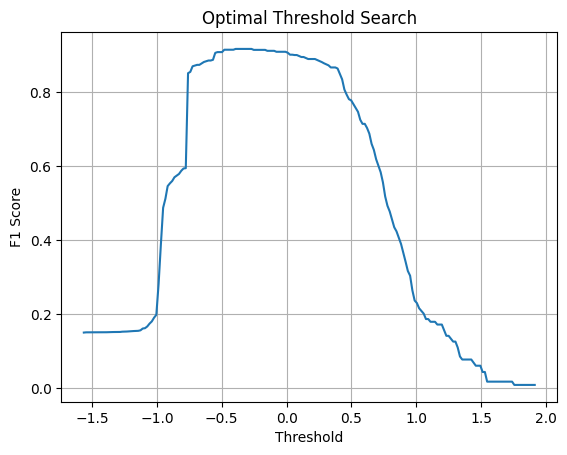

In [22]:
ts = [r[0] for r in results]
fs = [r[1] for r in results]

plt.plot(ts, fs)
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("Optimal Threshold Search")
plt.grid(True)
plt.show()


In [23]:
print(f"Optimal Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1}")


Optimal Threshold: -0.39276911945606163
Best F1 Score: 0.91725768321513
